## 1. Make classification data and get it ready

In [26]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [27]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [28]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y
                        })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [29]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

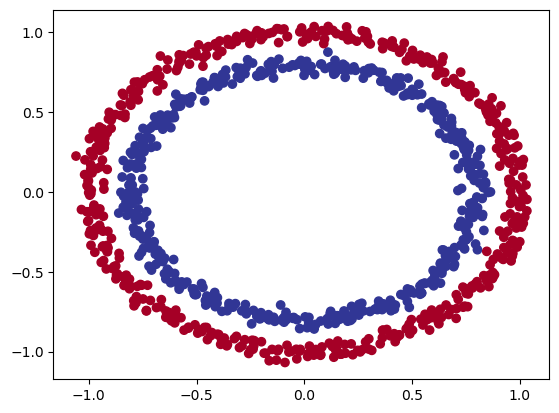

In [30]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

Note: This dataset is often what's considered a **toy problem** (a problem that's used to try and test things out on) in machine learning.

But it represents the major key of classification, you have some kind of data represented as numerical values and you'd like to build a model that's able to classify it, in our case, separate it into red or blue dots.

### 1.1 Input and output shapes

In [31]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [32]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

We have two inputs for one output.

### 1.2 Turn data into tensors and create train and test splits

In [33]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
from torch import nn

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [34]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [35]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [36]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

The only major change is what's happening between self.layer_1 and self.layer_2.

self.layer_1 takes 2 input features in_features=2 and produces 5 output features out_features=5.

This is known as having 5 hidden units or neurons.

This layer turns the input data from having 2 features to 5 features.

Why do this?

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

I say potentially because sometimes it doesn't work.

The number of hidden units you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

Since our dataset is small and simple, we'll keep it small.

The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features.

That's why self.layer_2 has in_features=5, it takes the out_features=5 from self.layer_1 and performs a linear computation on them, turning them into out_features=1 (the same shape as y).

In [38]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)


Woah, that looks much simpler than subclassing nn.Module, why not just always use nn.Sequential?

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

Now we've got a model, let's see what happens when we pass some data through it.

In [39]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.9080],
        [1.1242],
        [0.3702],
        [1.0603],
        [0.4159],
        [0.5475],
        [1.1199],
        [0.9850],
        [0.3691],
        [1.1392]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

- **SGD Optimizer**:
  - For classification, regression, and more.
  - Code: `torch.optim.SGD()`

- **Adam Optimizer**:
  - For classification, regression, and more.
  - Code: `torch.optim.Adam()`

- **Binary Cross Entropy Loss**:
  - For binary classification.
  - Code: `torch.nn.BCELoss` or `torch.nn.BCEWithLogitsLoss`

- **Cross Entropy Loss**:
  - For multi-class classification.
  - Code: `torch.nn.CrossEntropyLoss`

- **Mean Absolute Error (MAE) Loss**:
  - For regression.
  - Code: `torch.nn.L1Loss`

- **Mean Squared Error (MSE) Loss**:
  - For regression.
  - Code: `torch.nn.MSELoss`

Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

Note: Recall a loss function is what measures how wrong your model predictions are, the higher the loss, the worse your model.

Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

- **torch.nn.BCELoss()**:
  - Measures binary cross entropy between target (label) and input (features).
  - Requires a separate `nn.Sigmoid()` before applying loss.

- **torch.nn.BCEWithLogitsLoss()**:
  - Combines sigmoid activation and binary cross entropy in one step.
  - More numerically stable than BCELoss with separate sigmoid.

- **Recommendation**:
  - Use **BCEWithLogitsLoss()** in most cases for better stability.
  - Separate sigmoid and BCELoss for advanced use cases.

In [40]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

In [42]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

Forward pass - The model goes through all of the training data once, performing its forward() function calculations `(model(x_train))`.

Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are `(loss = loss_fn(y_pred, y_train)`.

Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step `(optimizer.zero_grad())`.

Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropagation, hence "backwards" (`loss.backward()`).

Step the optimizer (gradient descent) - Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them (`optimizer.step()`).

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [44]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
print(y_logits)

tensor([[0.9080],
        [1.1242],
        [0.3702],
        [1.0603],
        [0.4159]], device='cuda:0', grad_fn=<SliceBackward0>)


Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our forward() method.

Which implements two layers of nn.Linear() which internally calls the following equation:

y = x.w^T + b

The raw outputs (unmodified) of this equation ($y$) and in turn, the raw outputs of our model are often referred to as logits.

That's what our model is outputing above when it takes in the input data ($x$ in the equation or X_test in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

In [46]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)

tensor([[0.7126],
        [0.7548],
        [0.5915],
        [0.7428],
        [0.6025]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

They're now in the form of prediction probabilities (I usually refer to these as y_pred_probs), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

- If y_pred_probs >= 0.5, y=1 (class 1)
- If y_pred_probs < 0.5, y=0 (class 0)

To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [47]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [48]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

This means we'll be able to compare our model's predictions to the test labels to see how well it's performing.

To recap, we converted our model's raw outputs (logits) to prediction probabilities using a sigmoid activation function.

And then converted the prediction probabilities to prediction labels by rounding them.

Note: The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function (this will come later on).

And the use of the sigmoid activation function is not required when passing our model's raw outputs to the nn.BCEWithLogitsLoss (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

### 3.2 Building a training and testing loop

In [49]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.75643, Accuracy: 50.00% | Test loss: 0.77209, Test acc: 50.00%
Epoch: 10 | Loss: 0.71811, Accuracy: 53.62% | Test loss: 0.73119, Test acc: 53.50%
Epoch: 20 | Loss: 0.70376, Accuracy: 55.50% | Test loss: 0.71461, Test acc: 50.50%
Epoch: 30 | Loss: 0.69822, Accuracy: 53.12% | Test loss: 0.70738, Test acc: 49.00%
Epoch: 40 | Loss: 0.69598, Accuracy: 52.38% | Test loss: 0.70390, Test acc: 48.00%
Epoch: 50 | Loss: 0.69499, Accuracy: 51.50% | Test loss: 0.70199, Test acc: 47.00%
Epoch: 60 | Loss: 0.69450, Accuracy: 51.50% | Test loss: 0.70080, Test acc: 46.00%
Epoch: 70 | Loss: 0.69422, Accuracy: 51.00% | Test loss: 0.69998, Test acc: 47.00%
Epoch: 80 | Loss: 0.69403, Accuracy: 50.75% | Test loss: 0.69935, Test acc: 45.50%
Epoch: 90 | Loss: 0.69389, Accuracy: 50.88% | Test loss: 0.69885, Test acc: 46.00%


The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

## 4. Make predictions and evaluate the model

In [50]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


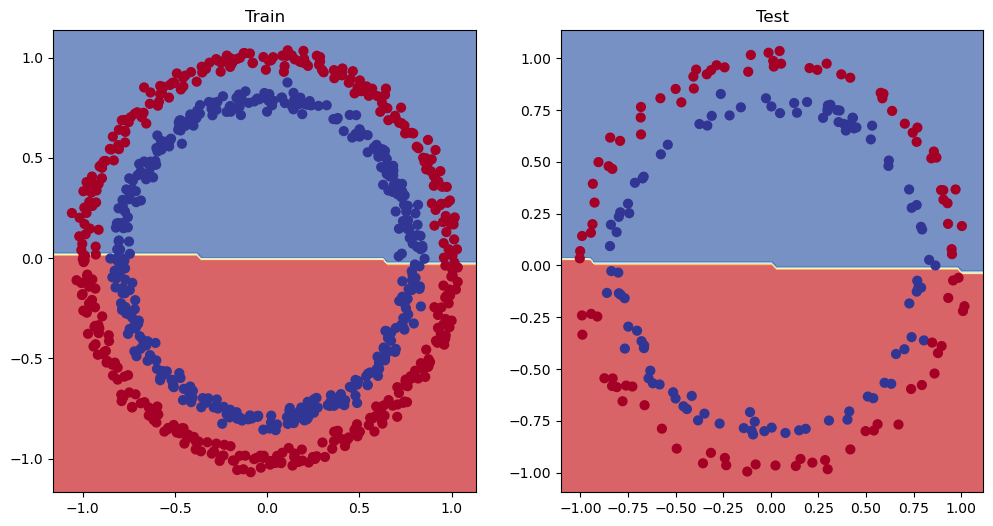

In [51]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Oh wow, it seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.

## 5. Improving a model (from a model perspective)

- **Add more layers**:
  - Increases model's ability to learn complex patterns.
  - Makes the network "deeper."

- **Add more hidden units**:
  - Increases model’s learning capacity within each layer.
  - Makes the network "wider."

- **Fitting for longer (more epochs)**:
  - Allows the model to learn more by seeing the data multiple times.

- **Changing activation functions**:
  - Helps the model handle complex, non-linear patterns.

- **Change the learning rate**:
  - Controls how much the model changes during training.
  - Too high: model overcorrects; too low: model learns too slowly.

- **Change the loss function**:
  - Different problems need different loss functions (e.g., binary vs multi-class).

- **Use transfer learning**:
  - Use a pre-trained model and adjust it for your own problem.

Note: *because you can adjust all of these by hand, they're referred to as hyperparameters.

And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

In [52]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [53]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [54]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

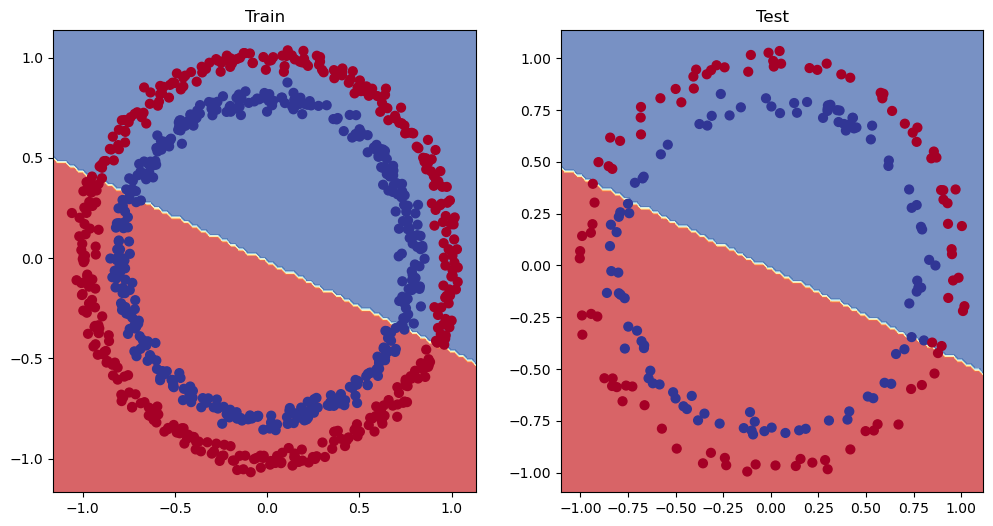

In [55]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Our model is still drawing a straight line between the red and blue dots.

If our model is drawing a straight line, could it model linear data?

### 5.1 Preparing data to see if our model can model a straight lin

In [56]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [57]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
      len(y_train_regression),
      len(X_test_regression),
      len(y_test_regression))

80 80 20 20


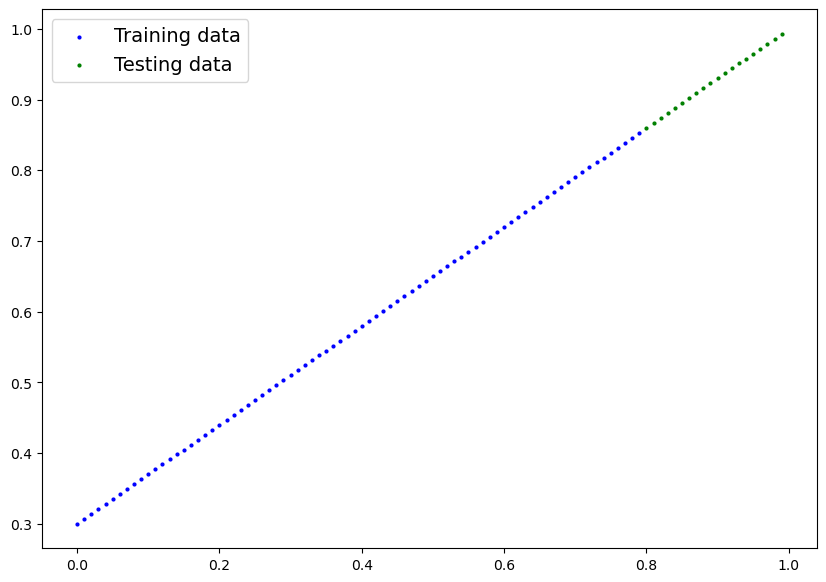

In [58]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression
                 );

### 5.2 Adjusting model_1 to fit a straight line

In [59]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [60]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [61]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_2(X_test_regression)
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


Okay, unlike model_1 on the classification data, it looks like model_2's loss is actually going down.

Let's plot its predictions to see if that's so.

And remember, since our model and data are using the target device, and this device may be a GPU, however, our plotting function uses matplotlib and matplotlib can't handle data on the GPU.

To handle that, we'll send all of our data to the CPU using .cpu() when we pass it to plot_predictions().

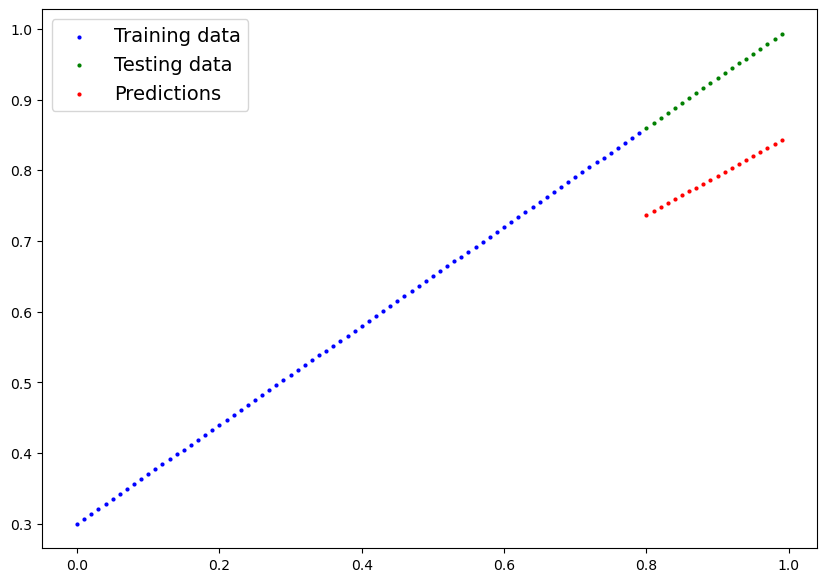

In [62]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

Alright, it looks like our model is able to do far better than random guessing on straight lines.

This is a good thing.

It means our model at least has some capacity to learn.

Note: A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.

This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then overfitting (making the model perform too well) on that small example before increasing the amount of data or the model size/design to reduce overfitting.

So what could it be?

## 6. The missing piece: non-linearity

We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines?

### 6.1 Recreating non-linear data (red and blue circles)

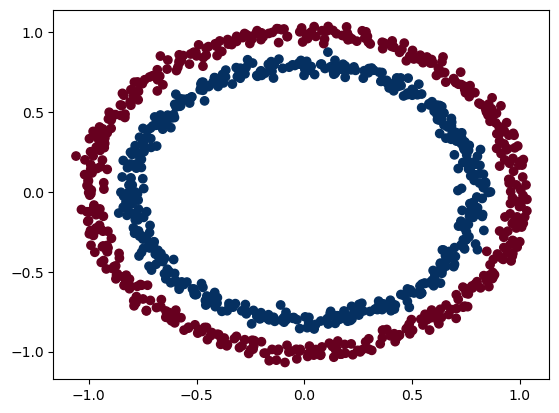

In [63]:
# Make and plot data
n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42,
                    )

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [64]:
# Convert to tensors and split into train and test sets
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [65]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


Question: Where should I put the non-linear activation functions when constructing a neural network?

A rule of thumb is to put them in between hidden layers and just after the output layer, however, there is no set in stone option. As you learn more about neural networks and deep learning you'll find a bunch of different ways of putting things together. In the meantime, best to experiment, experiment, experiment.

In [66]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [67]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


Ho ho! That's looking far better!

### 6.4 Evaluating a model trained with non-linear activation functions

In [68]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

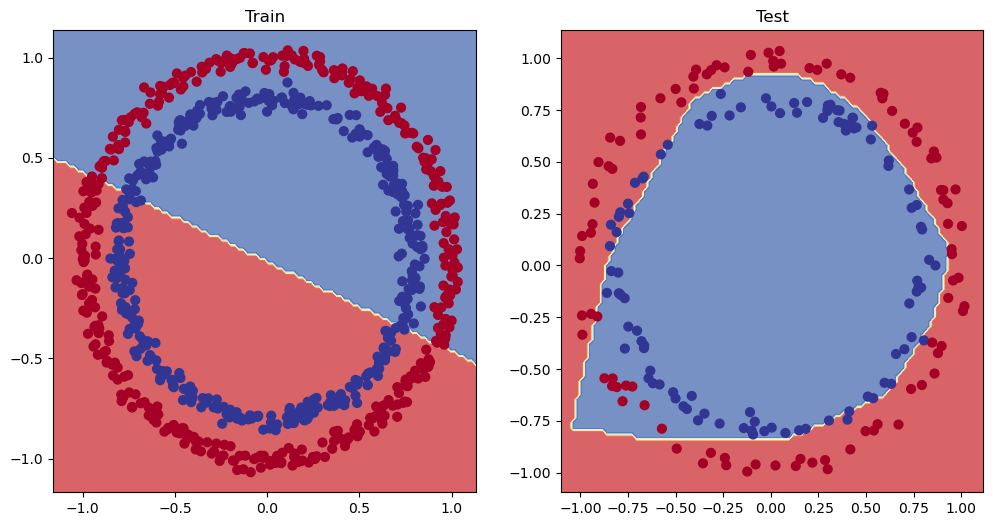

In [69]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Nice! Not perfect but still far better than before.

Potentially you could try a few tricks to improve the test accuracy of the model?

## 7. Replicating non-linear activation functions

We saw before how adding non-linear activation functions to our model can help it to model non-linear data.

Note: Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Right now we've been working with dots on a 2D plot. But imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes. Or text from Wikipedia you'd like to summarize, there's lots of different ways words can be put together (linear and non-linear patterns).

But what does a non-linear activation look like?

How about we replicate some and what they do?

Let's start by creating a small amount of data.

In [70]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

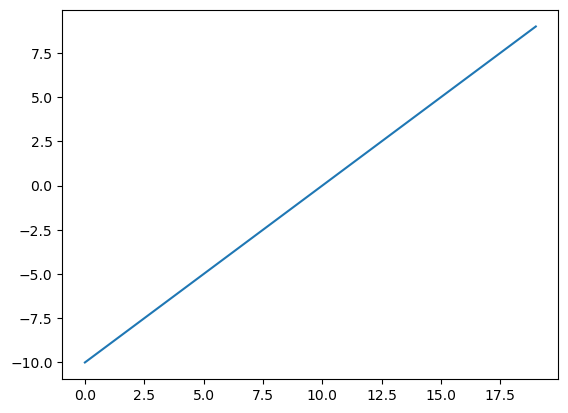

In [71]:
# Visualize the toy tensor
plt.plot(A)

A straight line, nice.

Now let's see how the ReLU activation function influences it.

And instead of using PyTorch's ReLU (torch.nn.ReLU), we'll recreate it ourselves.

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [72]:
# Create ReLU function by hand
def relu(x):
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

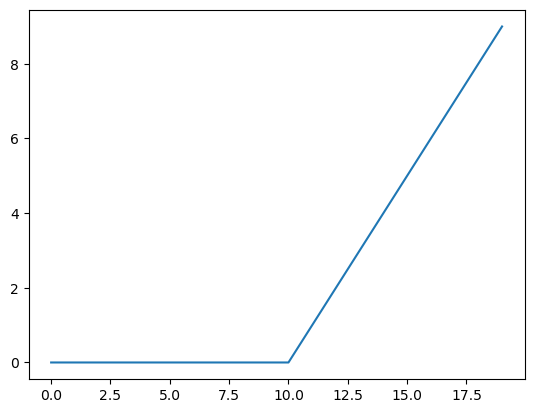

In [73]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

How about we try the sigmoid function we've been using?

The sigmoid function formula goes like so:

$$ out_i = \frac{1}{1+e^{-input_i}} $$

Or using $x$ as input:

$$ S(x) = \frac{1}{1+e^{-x_i}} $$

Where $S$ stands for sigmoid, $e$ stands for exponential (torch.exp()) and $i$ stands for a particular element in a tensor.

Let's build a function to replicate the sigmoid function with PyTorch.

In [74]:
# Create a custom sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

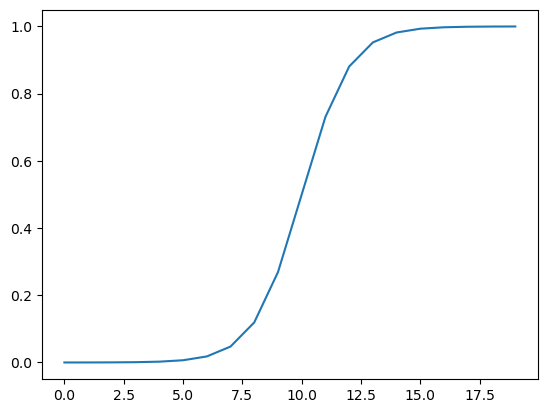

In [75]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

Looking good! We've gone from a straight line to a curved line.

Now there's plenty more non-linear activation functions that exist in PyTorch that we haven't tried.

But these two are two of the most common.

And the point remains, what patterns could you draw using an unlimited amount of linear (straight) and non-linear (not straight) lines?

Almost anything right?

That's exactly what our model is doing when we combine linear and non-linear functions.

Instead of telling our model what to do, we give it tools to figure out how to best discover patterns in the data.

And those tools are linear and non-linear functions.

## 8. Putting things together by building a multi-class PyTorch model

Recall a binary classification problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a multi-class classification problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).

### 8.1 Creating multi-class classification data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's make_blobs() method.

This method will create however many classes (using the centers parameter) we want.

Specifically, let's do the following:

Create some multi-class data with make_blobs().
Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
Split the data into training and test sets using train_test_split().
Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


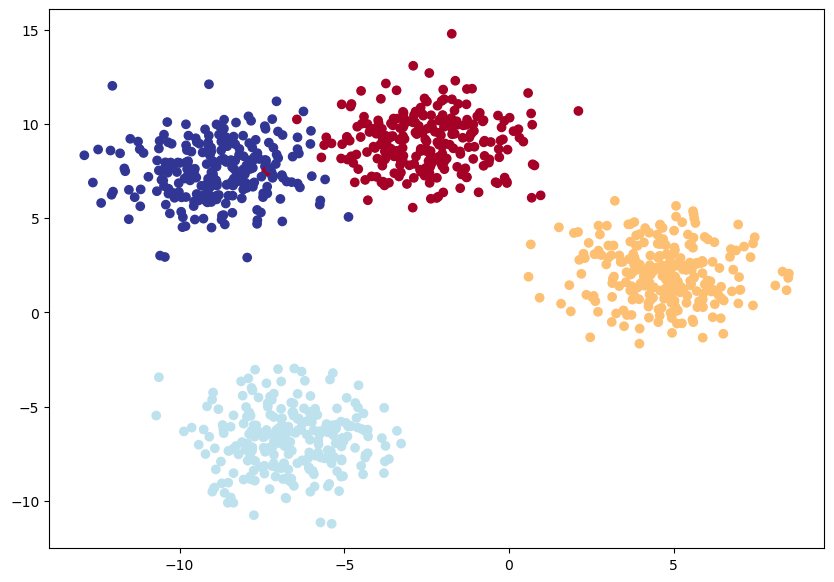

In [80]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES, # X features
                            centers=NUM_CLASSES, # y labels
                            cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
                            random_state=RANDOM_SEED
                            )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED
                                                                        )

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

cluster_std=1.5: Controls how spread out the clusters are (higher value = more spread out).

Nice! Looks like we've got some multi-class data ready to go.

Let's build a model to separate the coloured blobs.

Question: Does this dataset need non-linearity? Or could you draw a succession of straight lines to separate it?

### 8.2 Building a multi-class classification model in PyTorch

In [77]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [78]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [81]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [83]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
print(model_4(X_blob_train.to(device))[:5])

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)


What's coming out here?

It looks like we get one value per feature of each sample.

In [84]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

Wonderful, our model is predicting one value for each class that we have.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

That's where the softmax activation function comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

Logits: The raw outputs from the model, often referred to as "scores." These scores are not probabilities yet.

Softmax: The softmax function converts the logits into probabilities, so that each predicted value is between 0 and 1 and the sum of all probabilities for a sample is 1.

In [85]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


It may still look like the outputs of the softmax function are jumbled numbers (and they are, since our model hasn't been trained and is predicting using random patterns) but there's a very specific thing different about each sample.

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [86]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

These prediction probabilities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.(After softmax, each sample has a set of probabilities for each class. The model's prediction is the class with the highest probability.)

We can check which index has the highest value using torch.argmax().

torch.argmax(): This finds the index of the class with the highest probability, which is the predicted label.

In [87]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 3.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

Note: To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

### 8.5 Creating a training and testing loop for a multi-class PyTorch model

We've done many of these steps before so much of this will be practice.

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).